In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')


In [2]:
def create_damage_dict(interval=0.1):
    """Create a damage bin table

    Args:
        interval (float, optional): interval for each bin. Defaults to 0.1.
        We presently assume uniform spacing of the intervals

    Returns:
        `pd.DataFrame`: damage bin table with bin index values, start, end
        and interpolated values for each bin.
    """
    damage_bins = np.arange(0, 1.01, interval)
    damage_bins = np.insert(damage_bins, 0, 0)
    damage_bins = np.insert(damage_bins, -1, 1)
    interpvals = np.convolve(damage_bins, np.ones(2), 'valid')/2
    from_vals = damage_bins[:-1]
    to_vals = damage_bins[1:]
    bin_index = np.arange(1, len(to_vals)+1, dtype=int)
    damage_bin_dict = pd.DataFrame(data={'bin_index':bin_index,
                                         'bin_from': from_vals,
                                         'bin_to': to_vals,
                                         'interpolation': interpvals})
    damage_bin_dict['interval_type'] = 0
    damage_bin_dict.loc[damage_bin_dict.bin_from == damage_bin_dict.bin_to, 'interval_type']=1203
    damage_bin_dict.loc[damage_bin_dict.bin_from != damage_bin_dict.bin_to, 'interval_type']=1202
    damage_bin_dict.loc[1, 'interval_type'] = 1200
    return damage_bin_dict

In [3]:
def create_intensity_dict(iml, interval=5):
    """Create intensity bin dictionary

    Here we assume the interval is constant through the range of intensity measures. 
    Future development would enable the interval to vary.
    
    Args:
        iml (`np.array`): intensity measure levels for the vulnerability function
        interval (int, optional): Interval used to define bins. Defaults to 5.

    Returns:
        `pd.DataFrame`: intensity bin dictionary (as a DataFrame)
    """
    intensity_bins = np.arange(iml.min(), iml.max()+1, interval)
    # Add an extra bin at the end
    intensity_bins = np.hstack([intensity_bins, intensity_bins[-1]])
    
    # This merely takes the average of the values at each edge of the bin.
    # More complicated interpolations could be used if the ranges are not 
    # equally spaced.
    intensity_interp_vals = np.convolve(intensity_bins, np.ones(2), 'valid')/2
    from_vals = intensity_bins[:-1]
    to_vals = intensity_bins[1:]
    bin_index = np.arange(1, len(to_vals)+1, dtype=int)
    intensity_bin_dict = pd.DataFrame(data={'bin_index':bin_index, 
                                            'bin_from': from_vals, 
                                            'bin_to': to_vals, 
                                            'interpolation': intensity_interp_vals})
    # Set interval type value. The interval type == 1202 for a range, 1203 for single value
    intensity_bin_dict['interval_type'] = 0
    intensity_bin_dict.loc[intensity_bin_dict.bin_from == intensity_bin_dict.bin_to, 'interval_type']=1203
    intensity_bin_dict.loc[intensity_bin_dict.bin_from != intensity_bin_dict.bin_to, 'interval_type']=1202
    return intensity_bin_dict

In [4]:
def translate_house(di, iml, intensity_bin_dict, damage_bin_dict, id=1):
    """
    Take an array representing the loss ratios of a set of buildings and translate into a 

    Args:
        di (`np.ndarray`): Loss ratio (also damage index) for a number of assets at defined intensity measure levels
        iml (`np.ndarray`): Intensity measure levels
        intensity_bin_dict (`pd.DataFrame`): Intensity bins - each bin represents a range of intensity measure levels
        damage_bins (_type_): Damage bins - each bin represents a range of loss ratio levels
        id (int, optional): Asset id number. Defaults to 1, but *must* be incremented if more than one building type is being translated.

    Returns:
        `pd.DataFrame`: _description_
    """
    output = []
    damage_bins = np.insert(damage_bin_dict.bin_from.values, -1, 1)
    damage_bins = damage_bin_dict.bin_to.values
    for i, row in intensity_bin_dict.iterrows():
        idxmin = iml.tolist().index(row.bin_from)
        idxmax = iml.tolist().index(row.bin_to)
        if row.interval_type==1203:
            p = np.histogram(di[iml.tolist().index(row.bin_from), :], bins=damage_bins)[0]/di.shape[1]
        else:
            p = np.histogram(di[idxmin:idxmax, :], bins=damage_bins)[0]/di[idxmin:idxmax, :].size
        output.append(np.vstack([[i+1]*len(p), np.arange(len(p)) + 1, p]).T)

    vfunc = pd.DataFrame(data=np.vstack(output), columns=['intensity_bin_id', 'damage_bin_id', 'probability'])
    vfunc['vulnerability_id'] = id

    # Reorder the columns to match the Oasis format:
    cols = vfunc.columns.tolist()
    vfunc = vfunc[cols[-1:] + cols[:-1]]
    vfunc['intensity_bin_id'] = vfunc.intensity_bin_id.astype(int)
    vfunc['damage_bin_id'] = vfunc.damage_bin_id.astype(int)

    return vfunc[vfunc.probability!=0.0]

In [5]:
def parseVulnFile(filename):
    base, ext = os.path.splitext(filename)
    fh = h5py.File(filename, 'r')
    iml = fh['wind_speeds'][:]
    di = fh['house']['di'][:]
    intensity_bin_dict = create_intensity_dict(iml, 2)
    damage_bin_dict = create_damage_dict(0.05)
    vulnerability = translate_house(di, iml, intensity_bin_dict, damage_bin_dict)
    vulnerability.to_csv(base + '.csv')
    vulnerabilities_with_hazard_and_damage = vulnerability.merge(
        intensity_bin_dict, how='inner', 
        left_on='intensity_bin_id', right_on='bin_index').merge(
        damage_bin_dict, how='inner',
        suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

    fig = plt.figure(figsize=(10,10))

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(1, 1),
                    axes_pad=0.075,
                    share_all=True,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="single",
                    )

    vmin = 0.0
    vmax = max(vulnerabilities_with_hazard_and_damage.probability)
    labels = ["Residential"]

    for idx, ax in enumerate(grid):
        a = np.zeros((len(damage_bin_dict), len(intensity_bin_dict)))
        for index, row in vulnerabilities_with_hazard_and_damage[
            vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
            a[int(row.bin_index_d-1), int(row.bin_index_i-1)] = row.probability
        lev_exp = np.arange(-3, 0, 0.5)
        levs = np.power(10, lev_exp)
        xx, yy = np.meshgrid(
            intensity_bin_dict.interpolation,
            damage_bin_dict.interpolation*100
            )
        
        im = ax.pcolormesh(
            xx, yy, a, cmap=plt.get_cmap("Blues"),
            norm=colors.LogNorm(vmin=1e-2, vmax=a.max()))

        at = AnchoredText(
            labels[idx],
            prop=dict(size=8), frameon=True,
            loc=2,)

        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        ax.set_aspect(0.4)
        ax.set_xlabel("Intensity - Peak gust (m/s)")
        ax.set_ylabel("Damage")

        grid[0].cax.colorbar(im)
        cax = grid.cbar_axes[0]
        axis = cax.axis[cax.orientation]
        axis.label.set_text("Probability of damage")
        fig.tight_layout()
        ax.grid(which='both', linestyle=':')
    plt.savefig(base + ".png")

HouseType01_BaseCase_14Feb22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType01_RoofStructWindowDoor_29Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType01_RoofStruct_02Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType01_WindowDoor_28Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType02_BaseCase_15Feb22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType02_RoofStructWindowDoor_30Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType02_RoofStruct_09Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType02_WindowDoor_30Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType03_BaseCase_14Feb22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType03_RoofStructWindowDoor_29Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType03_RoofStruct_02Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType03_WindowDoor_28Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType05_BaseCase_14Feb22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


HouseType06_N4_WindowDoor_09Mar22.h5


C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(
C:\Users\u12161\AppData\Local\Temp\ipykernel_13760\1700893293.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid[0].cax.colorbar(im)


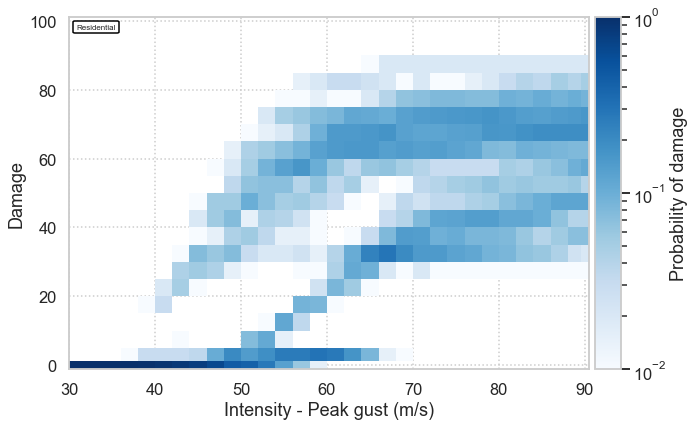

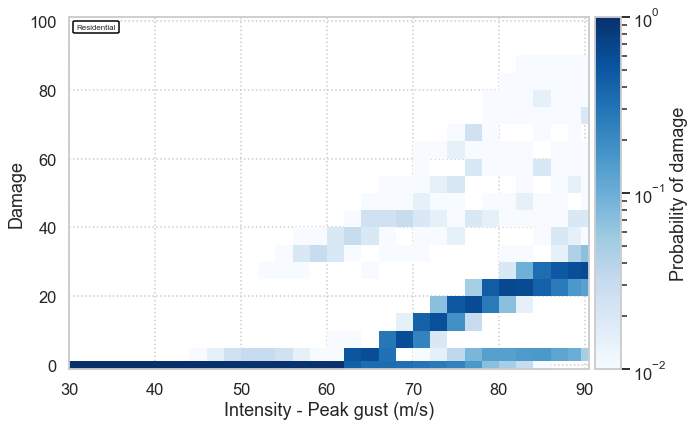

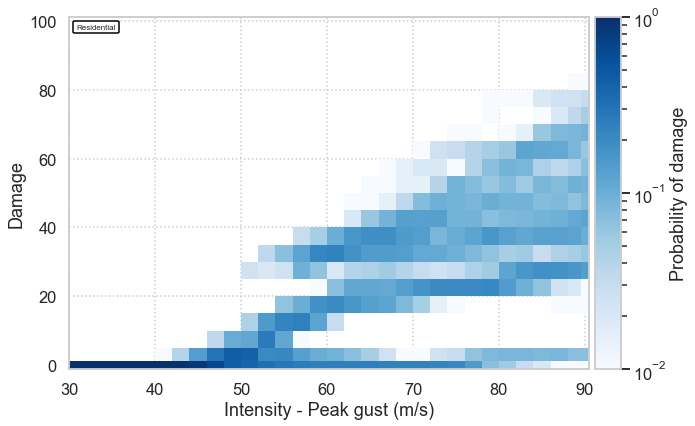

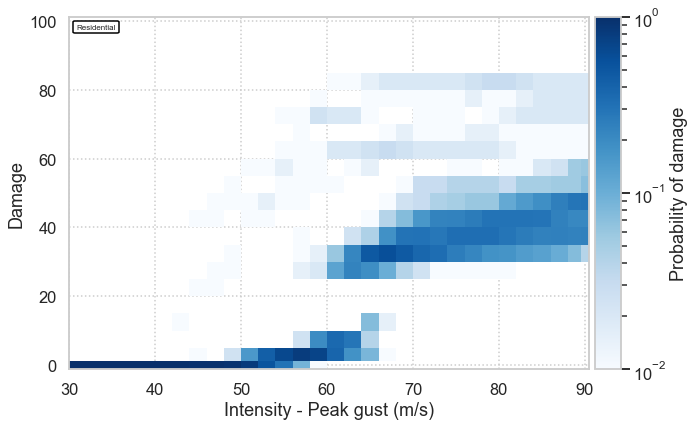

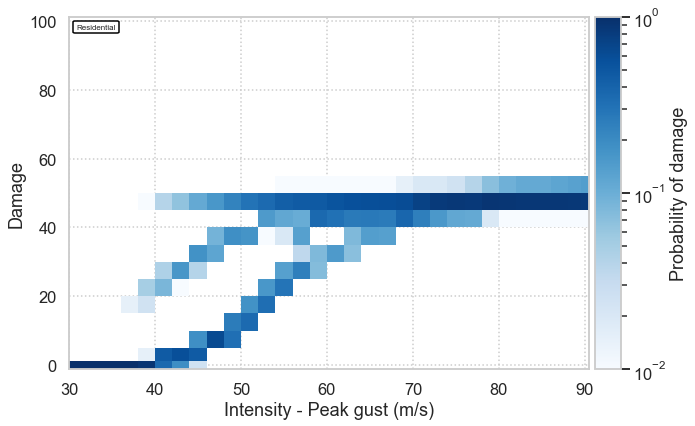

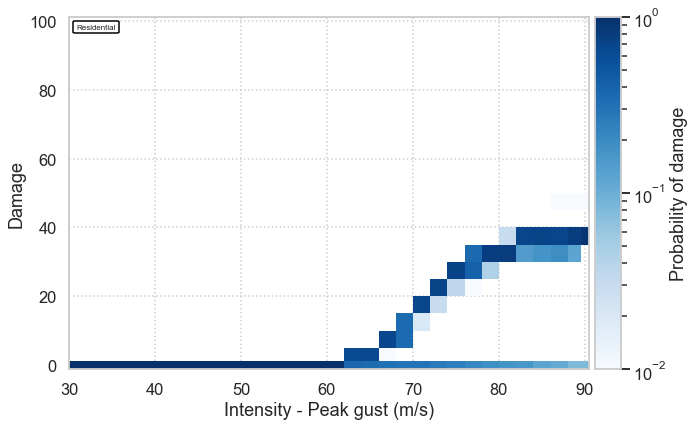

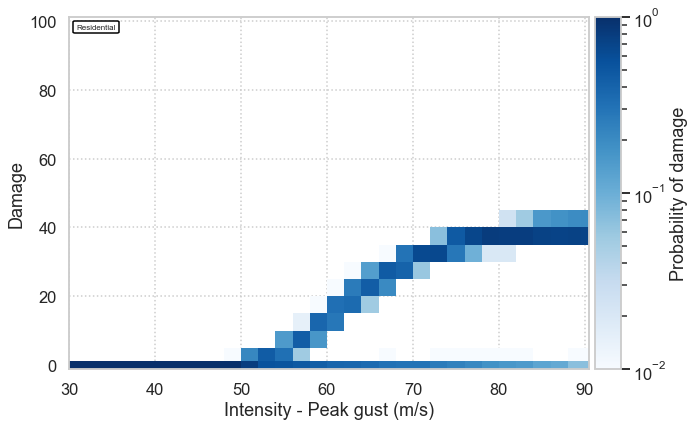

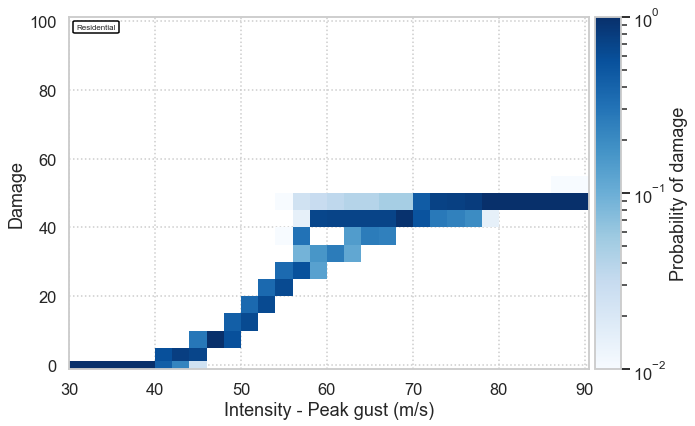

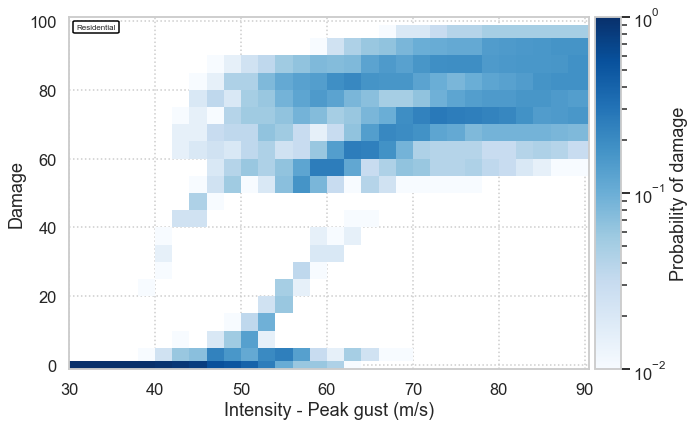

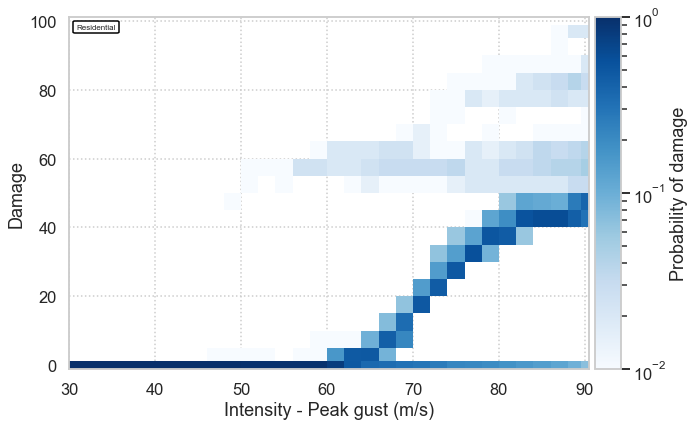

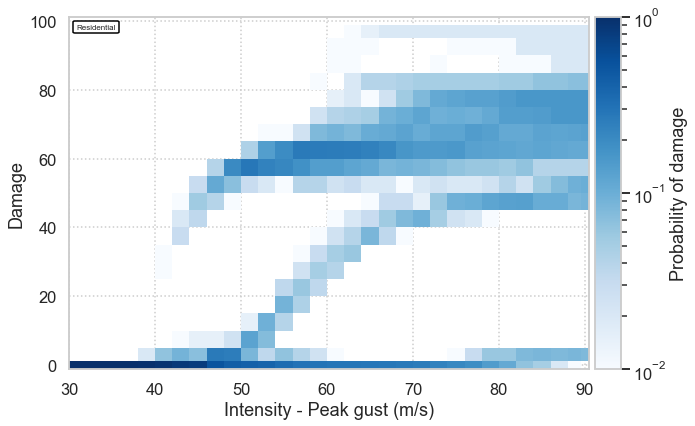

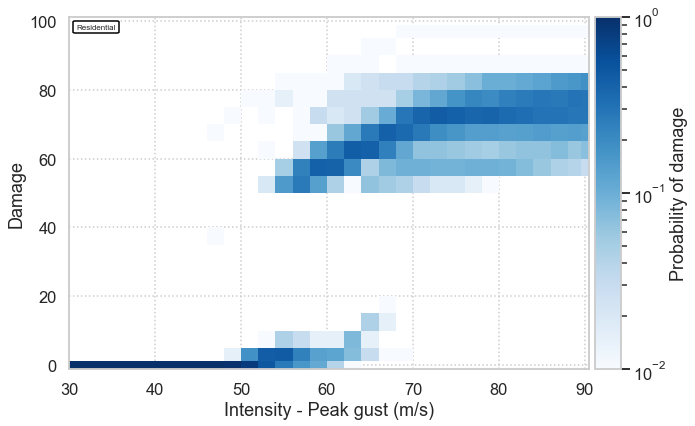

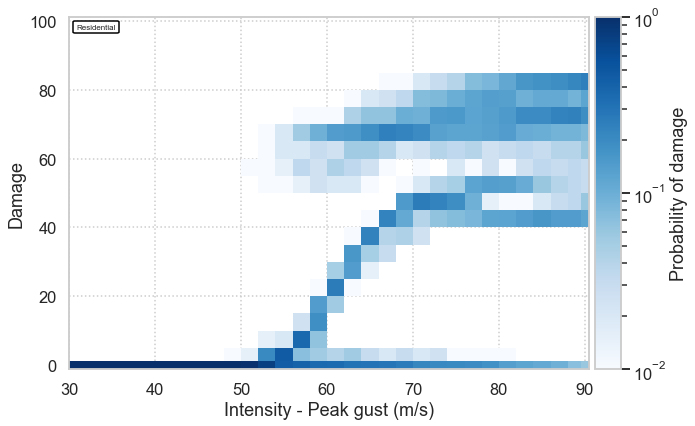

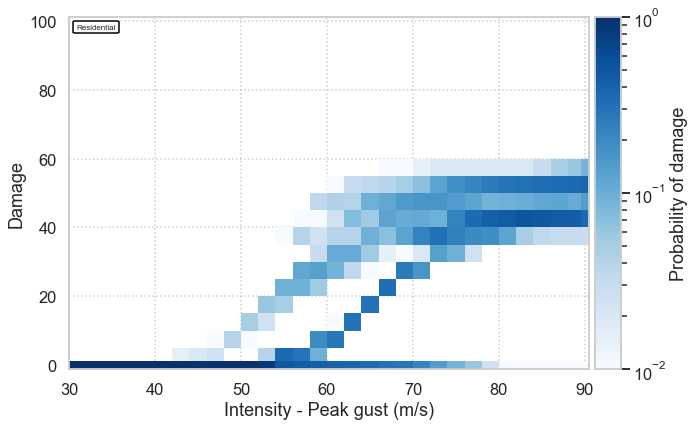

In [6]:
basedir = r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\DRAFT DATA STRUCTURES\2. Raw Data\External\James_Cook_University"

vulnfilelist = os.listdir(basedir)
for vulnfile in [vf for vf in vulnfilelist if vf.endswith('.h5')]:
    try:
        print(vulnfile)
        fh = h5py.File(os.path.join(basedir, vulnfile), 'r')
    except:
        print(f"Cannot read {vulnfile} as an hdf5 file")
        raise
    else:
        fh.close()
        parseVulnFile(os.path.join(basedir, vulnfile))
